# Exploring Model For Pollen Count

In this notebook, we will perform data preprocessing for the pollen count data. We will also apply feature selection methods on the dataset. We will try several regression models to compare and discuss the most reasonable and appropriate model.

In [1]:
import pickle
import datetime
import pandas as pd
import numpy as np

# visulization
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score


import math
from prophet import Prophet
from bayes_opt import BayesianOptimization


import warnings
# import shap
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

## Preprocessing Steps
First we load the backup datasets: weather dataset and the grass count dataset:

In [2]:
weather_dict = pickle.load(open('weather_v2.pkl', "rb"))
# grass_df = pd.read_csv('preprocessing/grass_clean_mel.csv')
grass_df = pd.read_csv('preprocessing/clean_data.csv')

grass_df['Count Date'] = grass_df['Count Date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
grass_df['non_grass'] = grass_df['Total'] - grass_df['grass_count']

According to the website of Melbourne pollen, the grass pollen is classified into four levels, low (0-19), medium(20-49), high(50-99) and extreme(100+). So we add "label" column in the grass dataset.

In [3]:
# define four labels
label = [[100, 1], [50, 2], [20, 3], [-1, 4]]

def get_label(x):
    """
    :desc:  
        Function which assigned label of grass count
    """
    for i in label:
        if x >= i[0]:
            return i[1]

# add new column "label"
grass_df['label'] = grass_df['grass_count'].apply(lambda x:get_label(x))

In [4]:
# extract full city names
grass_df['Name'] = grass_df['Name'].apply(lambda x:x.split('_')[0])
grass_df['Name'].value_counts()

Sydney                 4454
Tasmania               4049
Melbourne              2842
NSW-Westmead           1342
Canberra(2007-2017)    1301
Canberra                995
NSW-Gosford             854
NT                      809
Burwood                 406
Creswick                404
Geelong                 401
Dookie                  374
Churchill               365
Hamilton                355
Bendigo                 352
NSW-Wagga               247
Name: Name, dtype: int64

Now, we extract and merge data that only related to "Melbourne" and eatract the useful columns.

In [5]:
grass_columns = ['Count Date', 'Elevation', 'Total', 'Location', 'SchColTime', 'grass_count', 'label']
data = grass_df.loc[grass_df['Name']=='Melbourne'][grass_columns]

melbourne_df = pd.DataFrame()
weather_dict[1]['date'] = weather_dict[1].index

for i in [1, 25, 28, 29]:
    tmp = pd.merge(data.loc[data['Location']==i], weather_dict[1], left_on='Count Date', right_on='date', how='left')
    melbourne_df = pd.concat([melbourne_df, tmp])

Then, we process the new dataset by the following steps.
- drop unused colunms
- check the missing values and dual with the missing values
- sort the df in time order
- add a new column "year" to count each year's data

In [6]:
# 1. drop unused columns
melbourne_df = melbourne_df.drop(['Count Date', 'SchColTime'], axis=1)

In [7]:
# 2. check missing values
melbourne_df.isna().values.sum()

# dual with missing values
melbourne_df = melbourne_df.dropna()

In [8]:
# 3. sort the whole dataframe by date (in time order)
melbourne_df = melbourne_df.sort_values(by=['date'])

# 4. add a new column "year" to count each year's data
melbourne_df['year'] = melbourne_df['date'].dt.to_period("Y").astype(str)

# show the counts of each year
melbourne_df['year'].value_counts(ascending = False)

2017    127
2013    127
2019    118
2014     97
2016     96
2015     96
2012     95
2010     92
2001     92
2011     92
2008     92
2007     92
2006     92
2005     92
2003     92
2002     92
2009     92
2018     91
2000     91
2004     91
2020     89
2021     31
Name: year, dtype: int64

## Visualization
### 1) Correlation plot
In this part, we will show the correlation between each type of features (e.g. temperature, humidity, wind speed, etc.) and grass count. We fill find out the most related types of features through calculating the average correlation and select the types where their average correlation > 0.1.

In [9]:
def extract_df(feature, df, colnames):
    '''
    extract each type of features and grass count to a single dataframe
    '''
    all_list = list(filter(lambda x: feature in x, colnames))
    all_list.append('grass_count')
    all_list.append('year')
    one_df = df[all_list]

    return one_df

We record df of each type of feature and their correspoding avearge correlation values into two dictionaries.

In [10]:
feature_dict = {}
corr_dict = {}
colnames = melbourne_df.columns.to_list()
feature_type = ['av_abl_ht', 'accum_prcp', 'av_lwsfcdown', 'av_mslp', 'av_qsair_scrn', 'av_swsfcdown', 
                'av_temp_scrn', 'av_uwnd10m', 'av_vwnd10m', 'av_wndgust10m', 'dewpt_scrn', 'soil_mois', 
                'soil_temp', 'topt', 'thermal_time', 'Wind', 'precp', 'chilling_temp', 'forcing_temp']

for feature in feature_type:
    single_df = extract_df(feature, melbourne_df, colnames)
    # add df of each type of feature into dictionary
    feature_dict[feature] = single_df
    
    # calculate the correlation
    corr_cols = single_df.columns.to_list()
    corr = single_df[corr_cols].corr()
    # avergae correlation with grass count
    # remove last one since it is the correlation with itself = 1
    avg_corr = corr['grass_count'][:-1].sum()/len(corr['grass_count'][:-1])
    # record in dictionary
    corr_dict[feature] = avg_corr

In [11]:
# seperate single df
av_abl_ht_df = feature_dict[feature_type[0]] #10
accum_prcp_df = feature_dict[feature_type[1]] #16
av_lwsfcdown_df = feature_dict[feature_type[2]] #2
av_mslp_df = feature_dict[feature_type[3]] #14
av_qsair_scrn_df = feature_dict[feature_type[4]] #14
av_swsfcdown_df = feature_dict[feature_type[5]] #12
av_temp_scrn_df = feature_dict[feature_type[6]] #14
av_uwnd10m_df = feature_dict[feature_type[7]] #2
av_vwnd10m_df = feature_dict[feature_type[8]] #2
av_wndgust10m_df = feature_dict[feature_type[9]] #14
dewpt_scrn_df = feature_dict[feature_type[10]] #10
soil_mois_df = feature_dict[feature_type[11]] #7
soil_temp_df = feature_dict[feature_type[12]] #2
topt_df = feature_dict[feature_type[13]] #10
thermal_time_df = feature_dict[feature_type[14]]#5
wind_df = feature_dict[feature_type[15]] #8
precp_df = feature_dict[feature_type[16]]#9
chilling_temp_df = feature_dict[feature_type[17]] #10
forcing_temp_df = feature_dict[feature_type[18]] #10

In [12]:
# sort the dictionary of correlation and print out reaults where the correlation of type pf feature > 0.1
sorted_corr = sorted(corr_dict.items(), key=lambda item: item[1], reverse = True)
#sorted_dict = {k: v for k, v in sorted_tuples}
print(sorted_corr[:6])

[('av_temp_scrn', 0.2102167752237891), ('av_lwsfcdown', 0.17750794126802272), ('soil_temp', 0.15255700430071403), ('av_abl_ht', 0.14902721390655105), ('av_swsfcdown', 0.12110796905515298), ('thermal_time', 0.10207326500570071)]


Then, we can plot the correlation plots for visualization

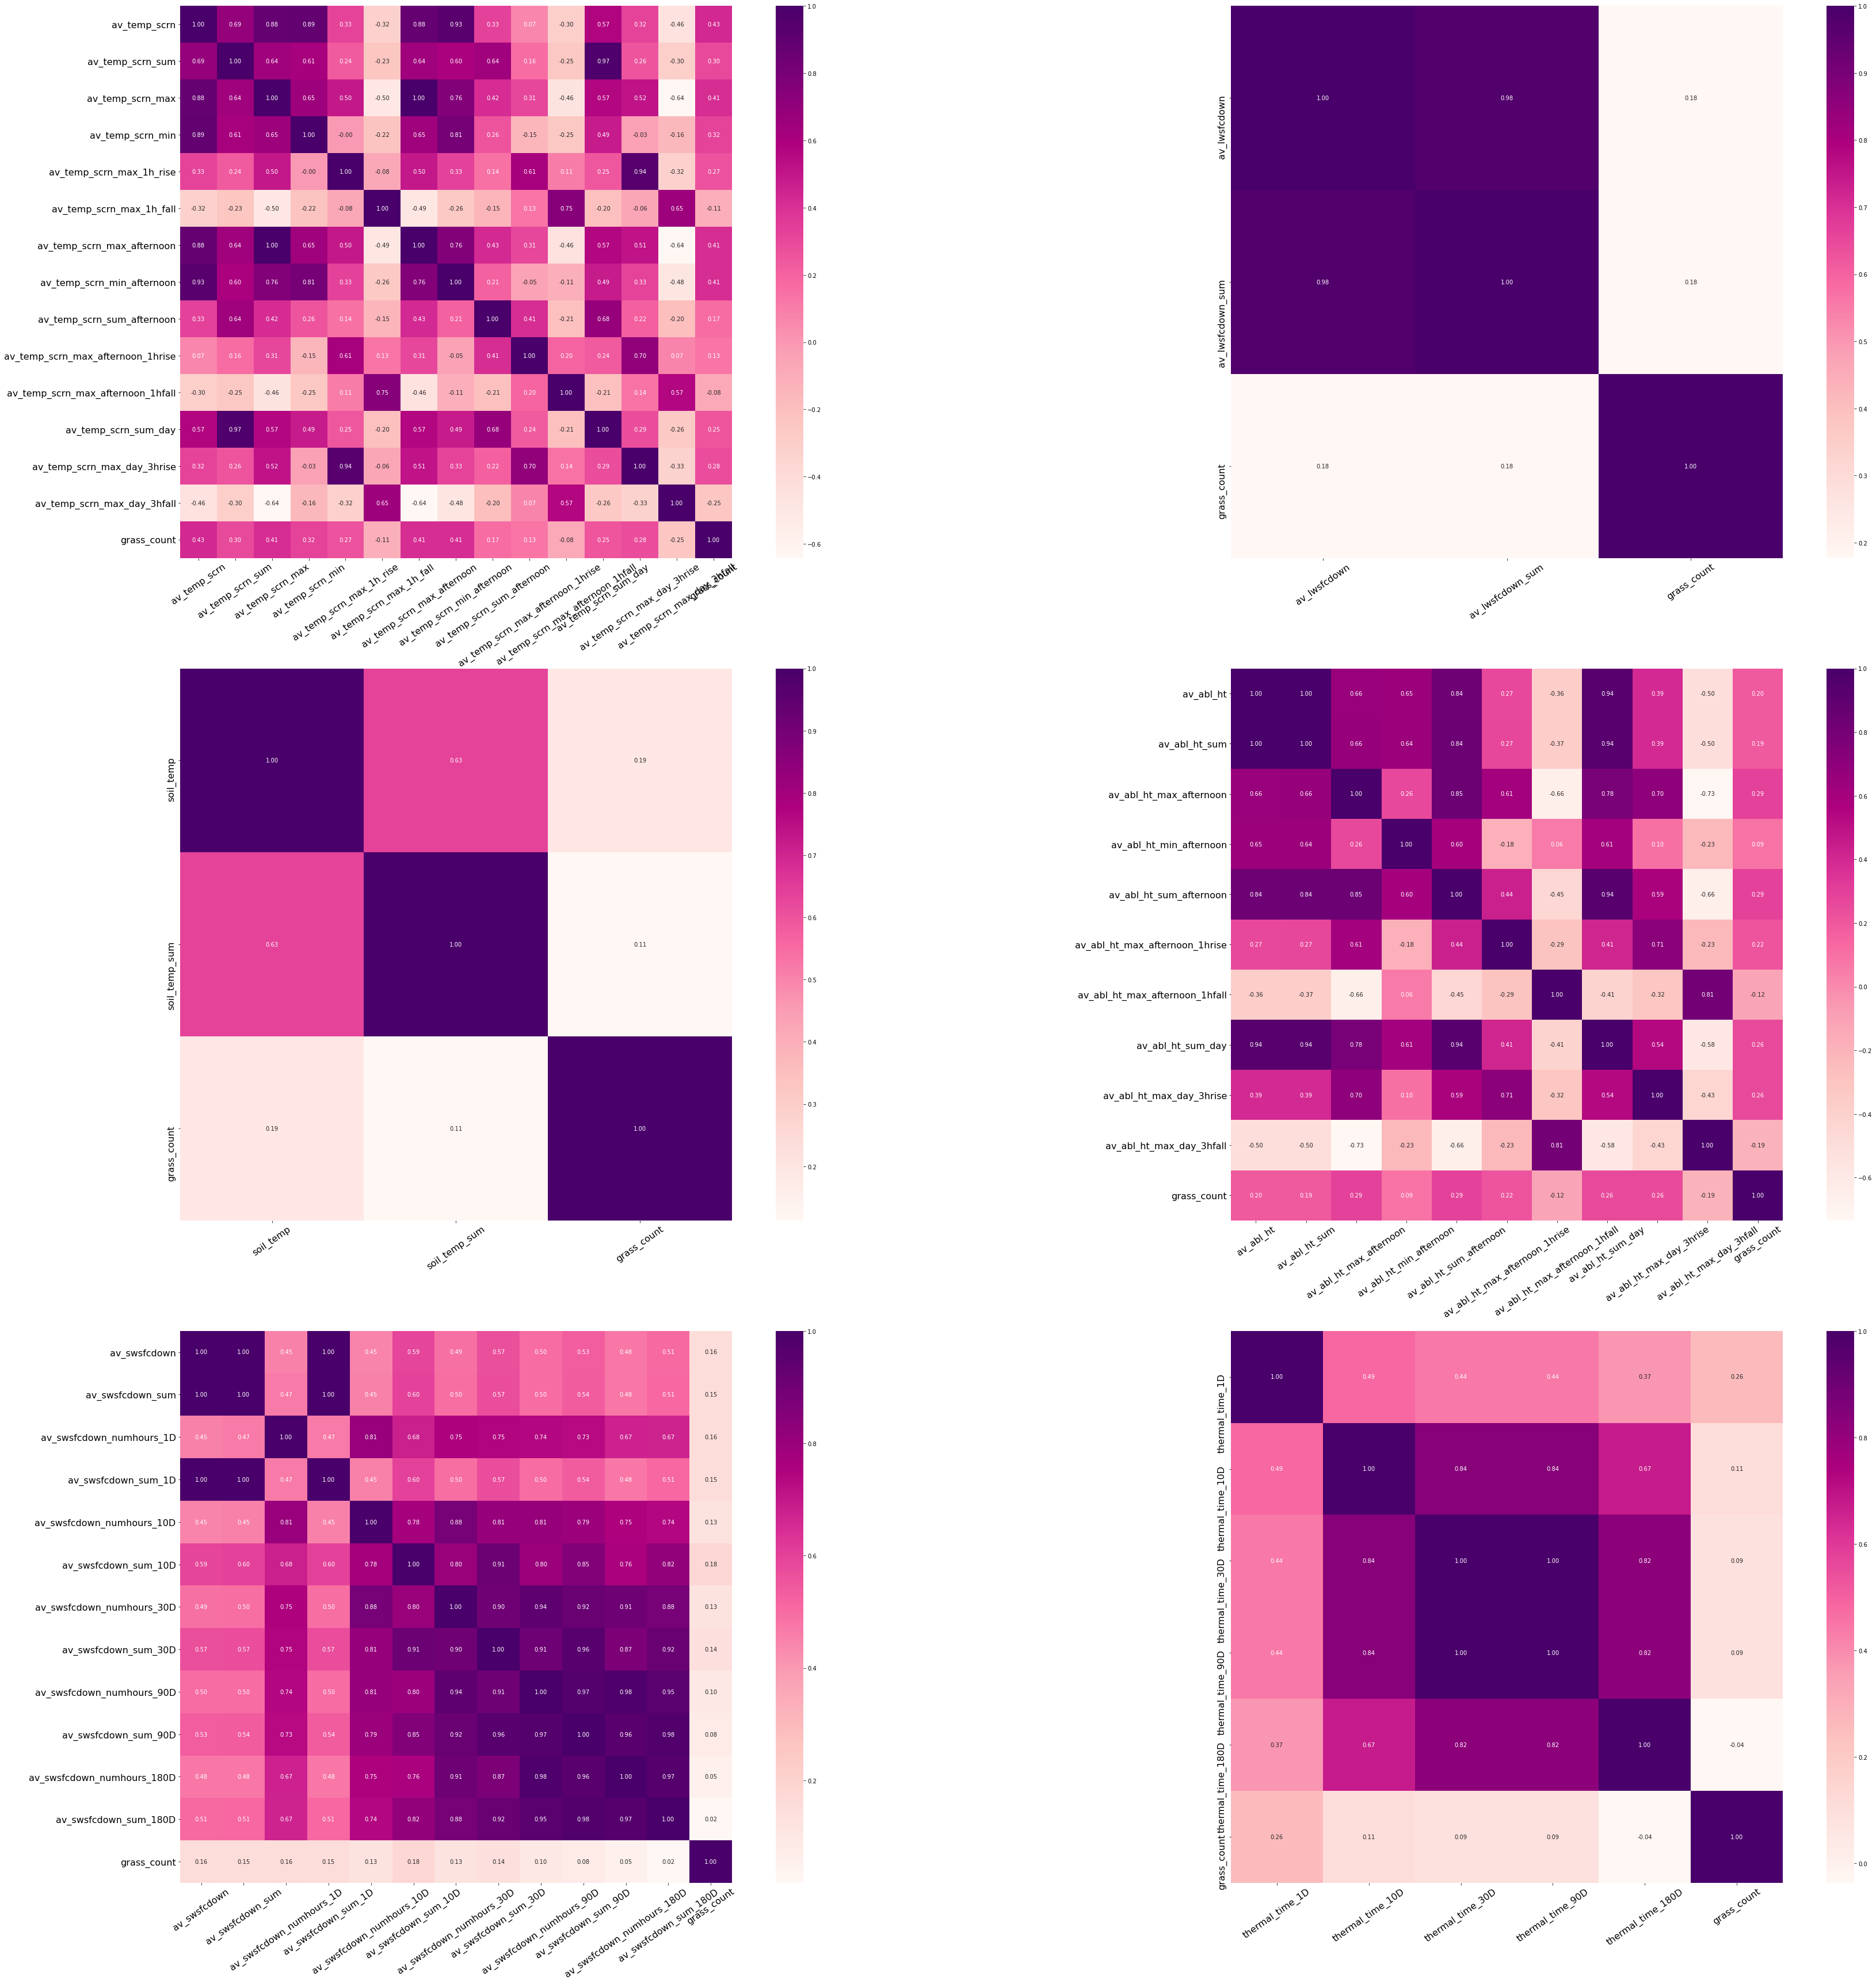

In [13]:
# correlation plot 
fig = plt.figure(figsize=(60, 60))
select = ['av_temp_scrn', 'av_lwsfcdown', 'soil_temp', 'av_abl_ht', 'av_swsfcdown', 'thermal_time']
for i in range(len(sorted_corr[:6])):
    fig.add_subplot(3, 2, i+1)
    corr_cols = feature_dict[select[i]].columns.to_list()
    corr = feature_dict[select[i]][corr_cols].corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='RdPu',         
            square=True, annot=True, fmt='.2f')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 16, rotation = 35)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 16)
plt.show()

### 2) Plot of grass pollen count for each year
In this part, we will show the grass pollen count for each year in general.

In [14]:
# change index for plot
visua_df = melbourne_df.reset_index()
visua_df['index'] = visua_df.index
visua_df.head()

,index,Elevation,Total,Location,grass_count,label,av_abl_ht,accum_prcp,av_lwsfcdown,av_mslp,...,thermal_time_30D,thermal_time_90D,thermal_time_180D,soil_mois_1D,soil_mois_10D,soil_mois_30D,soil_mois_90D,soil_mois_180D,date,year
0,0,13.0,76.0,25,4.0,4.0,1490.955,0.130126,291.743750,100769.72,...,90.375,90.375,476.875,2537.160156,25259.441406,73932.160156,214786.558594,413919.671875,2000-10-01,2000
1,1,13.0,63.0,25,2.0,4.0,1083.750,0.011325,312.027500,101798.64,...,90.875,90.875,477.125,2537.273438,25255.527344,73959.710938,214964.300781,414139.425781,2000-10-02,2000
2,2,13.0,65.0,25,6.0,4.0,990.995,0.002729,326.742500,102008.00,...,90.125,90.125,476.250,2536.863281,25253.625000,73984.609375,215138.472656,414358.984375,2000-10-03,2000
3,3,13.0,498.0,25,12.0,4.0,1080.790,0.000000,306.050625,101879.16,...,95.000,95.000,478.250,2534.246094,25254.082031,74023.683594,215475.507812,414795.257812,2000-10-05,2000
4,4,13.0,423.0,25,18.0,4.0,1495.965,0.000030,332.835625,101365.80,...,95.750,95.750,476.375,2532.039062,25254.269531,74037.093750,215637.449219,415010.820312,2000-10-06,2000


In [15]:
# group = visua_df.groupby('year')

# for group_name, df in group: 
#     fig = go.Figure() 
#     fig.add_trace(go.Scatter(x=df['date'], y=df['grass_count']))
#     fig.show()

In [16]:
group1 = visua_df.groupby('year')
fig1 = go.Figure()
fig2 = go.Figure()
for group_name, df in group1: 
    # by date (not continues)
    fig1.add_trace(go.Scatter(x=df['date'], y=df['grass_count'], name = group_name))
    
    # by year (continues)
    fig2.add_trace(go.Scatter(x=df['index'], y=df['grass_count'], name = group_name))
fig1.update_layout(height=600, width=900)
fig2.update_layout(height=600, width=900)

In [17]:
fig1.show()

In [18]:
fig2.show()

### 3) Distribution of grass pollen count 
In this part, we can visualize the target variable: grass pollen count. We can see most of the pollen days are low between 0 to 10.

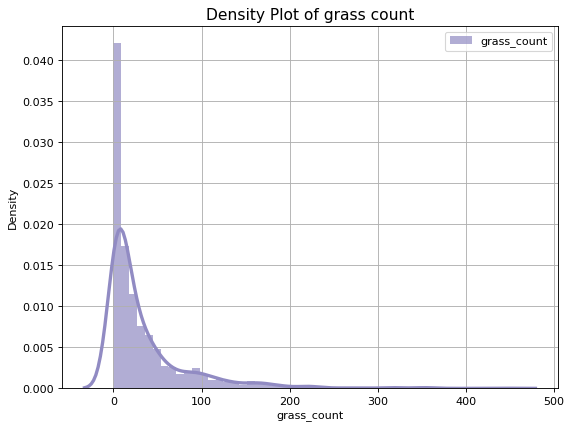

In [19]:
plt.figure(figsize=(8, 6), dpi=80)
sns.distplot(melbourne_df['grass_count'],
             color='#918BC3',
             label="grass_count",
             hist_kws={'alpha': .7},
             kde_kws={'linewidth': 3})
plt.grid(True)
plt.title('Density Plot of grass count', fontsize=14)
plt.legend()
plt.show()

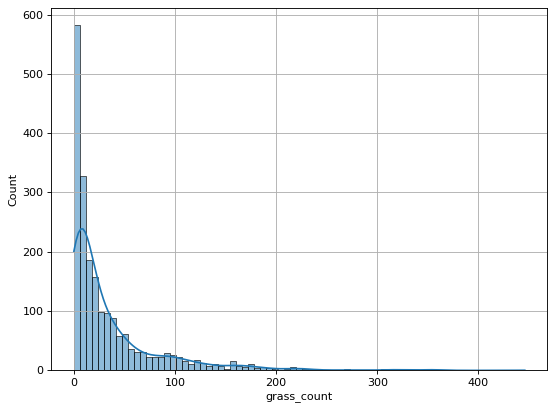

In [20]:
plt.figure(figsize=(8, 6), dpi=80)
# kernel density estimation (KDE) is the application of kernel smoothing for probability density estimation
sns.histplot(melbourne_df['grass_count'], kde=True)
plt.grid(True)

## Modelling
### Dataset
- We have 172 variables in total.</br>
- The numerical target variable is 'grass count'.
- We decide to use dataset from 2000 to 2019 as our training dataset.
- And the rest of the data are testing dataset, i.e., data of 2020 and 2021 (2020-10-02 to 2021-01-31)

### Type of model
#### <font color=Blue>1. Regression Model. LightBM Regressor</font>

<b>LightGBM is a gradient boosting framework that uses tree based learning algorithm.</b>

- Splits: LightGBM offers gradient-based one-side sampling (GOSS) that selects the split using all the instances with large gradients (i.e., large error) and a random sample of instances with small gradients. In order to keep the same data distribution when computing the information gain, GOSS introduces a constant multiplier for the data instances with small gradients. Thus, GOSS achieves a good balance between increasing speed by reducing the number of data instances and keeping the accuracy for learned decision trees. This method is not the default method for LightGBM, so it should be selected explicitly.

- Leaf growth: LightGBM uses leaf-wise (best-first) tree growth. It chooses to grow the leaf that minimizes the loss, allowing a growth of an imbalanced tree. Because it doesn’t grow level-wise, but leaf-wise, overfitting can happen when data is small. In these cases, it is important to control the tree depth. </br>

<i>ref: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc </i>

#### <font color=Blue>2. Navie forecasting method</font>
#### <font color=Blue>3. Prophet</font>

### Model 1. LightGBM Model

In [21]:
lgbm = LGBMRegressor()

#### LightGBM Model 1: use all features for prediction
Now, we need to split the dataset for training and testing.

In [22]:
# training dataset
train_data = melbourne_df.loc[(melbourne_df['year'] != "2020") & (melbourne_df['year'] != "2021")]
X_train = train_data.drop(['label', 'Total', 'Location', 'grass_count', 'year', 
                           'date'], axis = 1).reset_index(drop = True)
y_train = train_data['grass_count']
print(X_train.shape)
print(y_train.shape)

(1949, 172)
(1949,)


In [23]:
# testing dataset
test_data = melbourne_df.loc[(melbourne_df['year'] == "2020") | (melbourne_df['year'] == "2021")]
X_test = test_data.drop(['label', 'Total', 'Location', 'grass_count', 'year', 
                           'date'], axis = 1).reset_index(drop = True)
y_test = test_data['grass_count']
print(X_test.shape)
print(y_test.shape)

(120, 172)
(120,)


Then, we can apply LGBMRegressor on the dataset without tuning parameters as the baseline model.

In [24]:
lgbm.fit(X_train, y_train)

# Evaluation
print('The R2 score of prediction is: {}'.format(lgbm.score(X_test, y_test))) 

The R2 score of prediction is: 0.13503444192736969


To improve, we use grid search to tune the hyperparameters.

In [24]:
import time

def grid_search(pipeline, parameters, X, y):
    '''
    This function is used for grid search to tune the hyperparameters and find out the best one.
    '''
    gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    
    print('Performing grid search...')
    print('pipeline:', [name for name, _ in pipeline.steps])
    print('parameters:')
    print(parameters)
    t0 = time.time()
    gs.fit(X, y)
    print('done in %0.3fs' % (time.time() - t0))
    print()
    
    # print out best 5 results
    mean_score = gs.cv_results_['mean_test_score']
    param_set = gs.cv_results_['params']
    for i in mean_score.argsort()[-5:]:
        print(param_set[i])
        print(gs.cv_results_['mean_test_score'][i])
        print('='*30)
    
    return gs

##### Tuning the hyperparameters:
1. num_leaves: num_leaves is one of the most important parameters to control the complexity of the model. Large num_leaves can improve the accuracy of the training set and can also increase the chance of being injured by overfitting. A simple approach is that num_leaves = 2^(max_depth). We should tune num_leaves with the max_depth together.
2. max_depth: This parameter control max depth of each trained tree and will have impact on the best value for the num_leaves parameter, model performance and training time. model will likely be over fit  to the train set if we use a large value of max_depth.
3. min_data_in_leaf: min_data_in_leaf is the minimum number of records a leaf may have and usually deal with the overfitting problem.
4. bagging_fraction: bagging_fraction is the proportion of data used in each iteration to speed up training and reduce overfitting

In [25]:
lgbm_pipeline = Pipeline([
    ('clf', LGBMRegressor())
])

lgbm_param_grid = {
    'clf__max_depth': range(3, 8, 2),
    'clf__num_leaves':range(50, 160, 30),
    'clf__min_data_in_leaf':range(1,100, 10),
    'clf__bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
}

In [26]:
lgbm_gs = grid_search(lgbm_pipeline, lgbm_param_grid, X_train, y_train)
lgbm_gs_best = lgbm_gs.best_estimator_ 
print('Starting predicting...')
 

Performing grid search...
pipeline: ['clf']
parameters:
{'clf__max_depth': range(3, 8, 2), 'clf__num_leaves': range(50, 160, 30), 'clf__min_data_in_leaf': range(1, 100, 10), 'clf__bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]}
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
done in 190.574s

{'clf__bagging_fraction': 0.9, 'clf__max_depth': 7, 'clf__min_data_in_leaf': 61, 'clf__num_leaves': 140}
0.3502982191957953
{'clf__bagging_fraction': 0.6, 'clf__max_depth': 7, 'clf__min_data_in_leaf': 61, 'clf__num_leaves': 110}
0.3502982191957953
{'clf__bagging_fraction': 0.6, 'clf__max_depth': 7, 'clf__min_data_in_leaf': 61, 'clf__num_leaves': 50}
0.3502982191957953
{'clf__bagging_fraction': 1.0, 'clf__max_depth': 7, 'clf__min_data_in_leaf': 61, '

TypeError: type numpy.ndarray doesn't define __round__ method

In [30]:
# predict
y_pred_tune = lgbm_gs_best.predict(X_test)

np.rint(y_pred_tune)
# # evaluation
# print('='*25 + 'Evaluation results' + '='*25)
# print('The MSE of prediction is: {}'.format(mean_squared_error(y_test, y_pred_tune)))
# print('The RMSE of prediction is: {}'.format(math.sqrt(mean_squared_error(y_test, y_pred_tune))))
# print('The R2 score of prediction is: {}'.format(r2_score(y_test, y_pred_tune)))

array([  2.,  21.,  61.,  15.,  -1.,   3.,  21.,  -4.,  -4.,   1.,  -0.,
        26.,  -7.,  24.,   1.,   0.,  13.,  -9.,  -3.,  -2.,   6.,  10.,
       -10.,  -4.,   6.,   5.,  22.,  19.,  22.,  12.,   2.,  -2.,  66.,
       104.,   9.,   5.,  -2.,   2.,  33.,  81.,  98.,  35.,  17.,  98.,
        39.,  39.,  83., 131.,  48.,  56.,  85.,  31.,  23., 104.,  42.,
       123.,  53.,  28.,  79.,  60.,  40.,  46.,  53.,  73.,  66.,  16.,
        25.,  43.,  26.,  50.,  86.,  91., 104.,  73.,  45.,  76.,  31.,
        39.,  47.,  35.,  18.,  26.,  17.,  26., 101.,  70.,  24.,  30.,
        35.,  50.,  80.,  74.,  44.,  21.,  21.,  20.,  81.,  96., 110.,
       114., 101.,  20.,  57.,  34.,  17.,  22.,  11.,  29.,  12.,  62.,
        88.,  51.,  66.,  82.,  71.,  10.,  55.,  39.,  46.,  15.])

In [28]:
# convert prediction results to dataframe
result = pd.DataFrame(y_pred_tune)
result['test'] = list(y_test)
result['date'] = list(test_data['date'])
result = result.rename(columns = {0: 'prediction(all)'})

In [29]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=result)

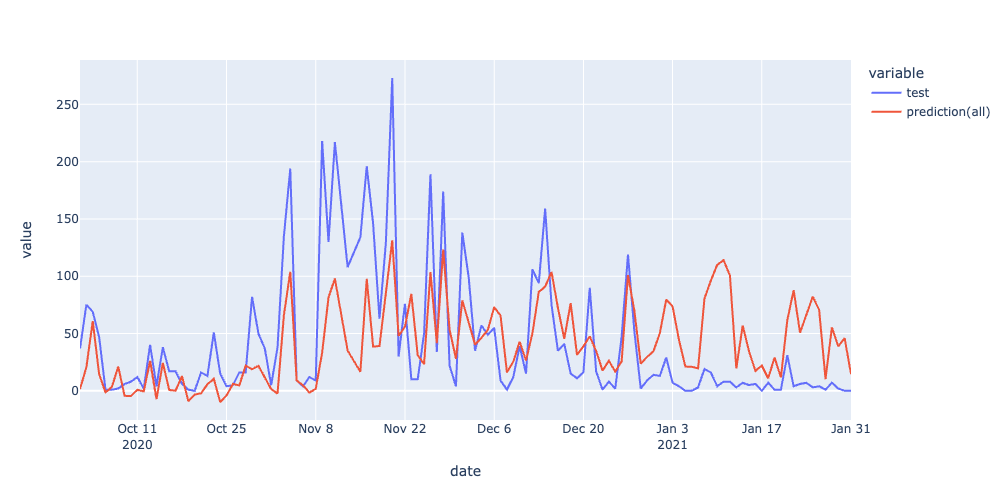

In [30]:
fig3 = go.Figure()
fig3 = px.line(result, x ='date', y= ['test', 'prediction(all)'], labels={'col1': "test", 'col2': "prediction(all)"})
fig3.update_layout(height=500, width=1000)
fig3.show()

#### LightGBM Model 2: use the most correlated feature for prediction (av_temp_scrn)
Now, we need to split the dataset for training and testing.

In [31]:
# training dataset
train_data1 = av_temp_scrn_df.loc[(av_temp_scrn_df['year'] != "2020") & (av_temp_scrn_df['year'] != "2021")]
X_train1 = train_data1.drop(['grass_count', 'year'], axis = 1).reset_index(drop = True)
#y_train1 = train_data1['grass_count']
print(X_train1.shape)
#print(y_train1.shape)

(1949, 14)


In [32]:
# testing dataset
test_data1 = av_temp_scrn_df.loc[(av_temp_scrn_df['year'] == "2020") | (av_temp_scrn_df['year'] == "2021")]
X_test1 = test_data1.drop(['grass_count', 'year'], axis = 1).reset_index(drop = True)
#y_test1 = test_data1['grass_count']
print(X_test1.shape)
#print(y_test1.shape)

(120, 14)


In [33]:
lgbm.fit(X_train1, y_train)

# Evaluation
print('The R2 score of prediction is: {}'.format(lgbm.score(X_test1, y_test))) 

The R2 score of prediction is: 0.18965149763034606


In [34]:
lgbm_pipeline1 = Pipeline([
    ('clf', LGBMRegressor())
])

lgbm_param_grid1 = {
    'clf__max_depth': range(2, 5, 1),
    'clf__num_leaves':range(10, 30, 5), 
    'clf__feature_fraction': [0.3, 0.4, 0.5],
    'clf__bagging_fraction': [0.3, 0.4, 0.5]
}

In [35]:
lgbm_gs1 = grid_search(lgbm_pipeline1, lgbm_param_grid1, X_train1, y_train)
lgbm_gs_best1 = lgbm_gs1.best_estimator_ 
print('Starting predicting...')

# predict
y_pred_tune1 = lgbm_gs_best1.predict(X_test1)

# evaluation
print('='*25 + 'Evaluation results' + '='*25)
print('The MSE of prediction is: {}'.format(mean_squared_error(y_test, y_pred_tune1)))
print('The RMSE of prediction is: {}'.format(math.sqrt(mean_squared_error(y_test, y_pred_tune1))))
print('The R2 score of prediction is: {}'.format(r2_score(y_test, y_pred_tune1))) 

Performing grid search...
pipeline: ['clf']
parameters:
{'clf__max_depth': range(2, 5), 'clf__num_leaves': range(10, 30, 5), 'clf__feature_fraction': [0.3, 0.4, 0.5], 'clf__bagging_fraction': [0.3, 0.4, 0.5]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
done in 2.058s

{'clf__bagging_fraction': 0.3, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves': 25}
0.17634349349354725
{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves': 10}
0.17634349349354725
{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves': 15}
0.17634349349354725
{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leav

In [36]:
result['prediction(temp)'] = list(y_pred_tune1)

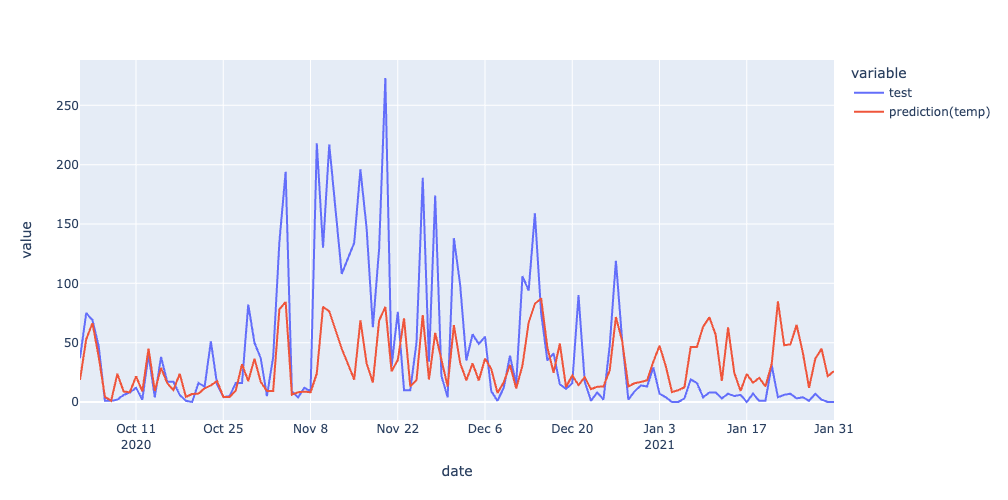

In [37]:
fig4 = go.Figure()
fig4 = px.line(result, x ='date', y= ['test', 'prediction(temp)'], labels={'col1': "test", 'col2': "prediction(temp)"})
fig4.update_layout(height=500, width=1000)
fig4.show()

#### LightGBM Model 3: use the most 2 correlated feature for prediction (av_temp_scrn and av_lwsfcdown)
Now, we need to split the dataset for training and testing.

In [38]:
av_lwsfcdown_df1 = av_lwsfcdown_df.copy()
av_lwsfcdown_df_raw = av_lwsfcdown_df1.drop(columns=['grass_count', 'year'])
df2 = pd.concat([av_temp_scrn_df, av_lwsfcdown_df_raw], axis = 1)

In [39]:
# training and testing dataset
train_data2 = df2.loc[(df2['year'] != "2020") & (df2['year'] != "2021")]
X_train2 = train_data2.drop(['grass_count', 'year'], axis = 1).reset_index(drop = True)

test_data2 = df2.loc[(av_temp_scrn_df['year'] == "2020") | (df2['year'] == "2021")]
X_test2 = test_data2.drop(['grass_count', 'year'], axis = 1).reset_index(drop = True)

print(X_train2.shape)
print(X_test2.shape)

(1949, 16)
(120, 16)


In [40]:
lgbm.fit(X_train2, y_train)

# Evaluation
print('The R2 score of prediction is: {}'.format(lgbm.score(X_test2, y_test))) 

The R2 score of prediction is: 0.23809630255884628


In [41]:
lgbm_gs2 = grid_search(lgbm_pipeline1, lgbm_param_grid1, X_train2, y_train)
lgbm_gs_best2 = lgbm_gs2.best_estimator_ 
print('Starting predicting...')

# predict
y_pred_tune2 = lgbm_gs_best2.predict(X_test2)

# evaluation
print('='*25 + 'Evaluation results' + '='*25)
print('The MSE of prediction is: {}'.format(mean_squared_error(y_test, y_pred_tune2)))
print('The RMSE of prediction is: {}'.format(math.sqrt(mean_squared_error(y_test, y_pred_tune2))))
print('The R2 score of prediction is: {}'.format(r2_score(y_test, y_pred_tune2))) 

Performing grid search...
pipeline: ['clf']
parameters:
{'clf__max_depth': range(2, 5), 'clf__num_leaves': range(10, 30, 5), 'clf__feature_fraction': [0.3, 0.4, 0.5], 'clf__bagging_fraction': [0.3, 0.4, 0.5]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
done in 2.073s

{'clf__bagging_fraction': 0.3, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves': 25}
0.1755790020968574
{'clf__bagging_fraction': 0.4, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves': 10}
0.1755790020968574
{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves': 10}
0.1755790020968574
{'clf__bagging_fraction': 0.3, 'clf__feature_fraction': 0.4, 'clf__max_depth': 2, 'clf__num_leaves'

#### LightGBM Model 3: use the most 6 correlated feature for prediction </br> (av_temp_scrn, av_lwsfcdown, soil_temp, av_abl_ht, av_swsfcdown, thermal_time)
Now, we need to split the dataset for training and testing.

In [42]:
soil_temp_df1 = soil_temp_df.copy()
soil_temp_df_raw = soil_temp_df1.drop(columns=['grass_count', 'year'])

av_abl_ht_df1 = av_abl_ht_df.copy()
av_abl_ht_df_raw = av_abl_ht_df1.drop(columns=['grass_count', 'year'])

av_swsfcdown_df1 = av_swsfcdown_df.copy()
av_swsfcdown_df_raw = av_swsfcdown_df1.drop(columns=['grass_count', 'year'])

thermal_time_df1 = thermal_time_df.copy()
thermal_time_df_raw = thermal_time_df1.drop(columns=['grass_count', 'year'])

In [43]:
df3 = pd.concat([df2, soil_temp_df_raw, av_abl_ht_df_raw, av_swsfcdown_df_raw, thermal_time_df_raw], axis=1)

In [44]:
# training and testing dataset
train_data3 = df3.loc[(df3['year'] != "2020") & (df3['year'] != "2021")]
X_train3 = train_data3.drop(['grass_count', 'year'], axis = 1).reset_index(drop = True)

test_data3 = df3.loc[(av_temp_scrn_df['year'] == "2020") | (df3['year'] == "2021")]
X_test3 = test_data3.drop(['grass_count', 'year'], axis = 1).reset_index(drop = True)

print(X_train3.shape)
print(X_test3.shape)

(1949, 45)
(120, 45)


In [45]:
lgbm.fit(X_train3, y_train)

# Evaluation
print('The R2 score of prediction is: {}'.format(lgbm.score(X_test3, y_test)))

The R2 score of prediction is: 0.18135099261668486


In [46]:
lgbm_gs3 = grid_search(lgbm_pipeline1, lgbm_param_grid1, X_train3, y_train)
lgbm_gs_best3 = lgbm_gs3.best_estimator_ 
print('Starting predicting...')

# predict
y_pred_tune3 = lgbm_gs_best3.predict(X_test3)

# evaluation
print('='*25 + 'Evaluation results' + '='*25)
print('The MSE of prediction is: {}'.format(mean_squared_error(y_test, y_pred_tune3)))
print('The RMSE of prediction is: {}'.format(math.sqrt(mean_squared_error(y_test, y_pred_tune3))))
print('The R2 score of prediction is: {}'.format(r2_score(y_test, y_pred_tune3))) 

Performing grid search...
pipeline: ['clf']
parameters:
{'clf__max_depth': range(2, 5), 'clf__num_leaves': range(10, 30, 5), 'clf__feature_fraction': [0.3, 0.4, 0.5], 'clf__bagging_fraction': [0.3, 0.4, 0.5]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
done in 3.952s

{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.3, 'clf__max_depth': 3, 'clf__num_leaves': 10}
0.30907933176110414
{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.3, 'clf__max_depth': 3, 'clf__num_leaves': 15}
0.30907933176110414
{'clf__bagging_fraction': 0.5, 'clf__feature_fraction': 0.3, 'clf__max_depth': 3, 'clf__num_leaves': 25}
0.30907933176110414
{'clf__bagging_fraction': 0.3, 'clf__feature_fraction': 0.3, 'clf__max_depth': 3, 'clf__num_leav